# Instacart Market Basket Analysis
## Which products will an Instacart consumer purchase again?

### Whether you shop from meticulously planned grocery lists or let whimsy guide your grazing, our unique food rituals define who we are. Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you. Instacart’s data science team plays a big part in providing this delightful shopping experience. Currently they use transactional data to develop models that predict which products a user will buy again, try for the first time, or add to their cart next during a session. Recently, Instacart open sourced this data - see their blog post on 3 Million Instacart Orders, Open Sourced.

### https://www.kaggle.com/c/instacart-market-basket-analysis/overview

## Import Required Libraries for EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

## Import all the required files to start the Analysis

In [2]:
orders= pd.read_csv("Data/orders.csv")
aisles=pd.read_csv("Data/aisles.csv")
product_priors=pd.read_csv("Data/order_products__prior.csv")
product_train=pd.read_csv("Data/order_products__train.csv")
dept=pd.read_csv("Data/departments.csv")
products=pd.read_csv("Data/products.csv")

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
product_priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
product_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
dept.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


# To understand the relation between the tables look at the image provided below

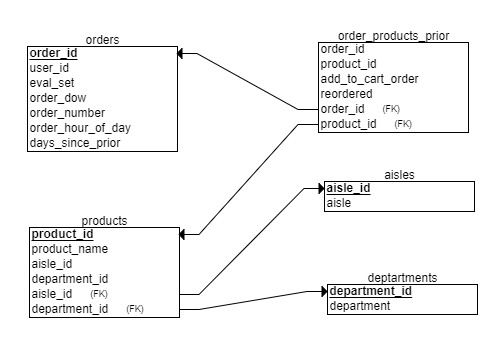

## Since it is Kaggle provided dataset there is a less chance of having any NULL/NA values but still we are going to check it specifically in the orders table as it is specified that it has some null values

In [9]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

## Lets see if the hour day of week column has all the possible values(i.e 0-23 hours and 0-6 day of week where 0 means Sunday) and also check the frequency

In [10]:
orders['order_dow'].unique()

array([2, 3, 4, 1, 5, 0, 6], dtype=int64)

In [11]:
hrs = sorted(orders['order_hour_of_day'].unique())
print(hrs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [12]:
dayOfWeek={1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 0:'Sunday'}
orders['weekday'] = orders['order_dow'].map(dayOfWeek)
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,weekday
0,2539329,1,prior,1,2,8,NaN,Tuesday
1,2398795,1,prior,2,3,7,15.0,Wednesday
2,473747,1,prior,3,3,12,21.0,Wednesday
3,2254736,1,prior,4,4,7,29.0,Thursday
4,431534,1,prior,5,4,15,28.0,Thursday
...,...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0,Friday
3421079,1854736,206209,prior,11,4,10,30.0,Thursday
3421080,626363,206209,prior,12,1,12,18.0,Monday
3421081,2977660,206209,prior,13,1,12,7.0,Monday


In [13]:
ord = orders['weekday'].value_counts()[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
ord

Monday       587478
Tuesday      467260
Wednesday    436972
Thursday     426339
Friday       453368
Saturday     448761
Sunday       600905
Name: weekday, dtype: int64

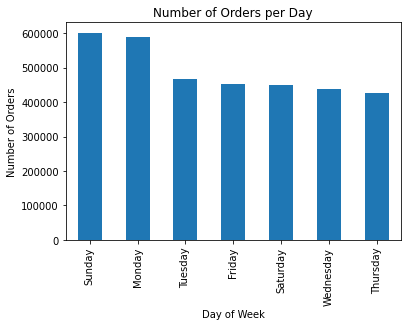

In [14]:
orders['weekday'].value_counts().plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Day')
plt.show()

## The basic thing that we can see that the orders are a bit more on Sunday and Monday which can be obvious considering that people are stocking for the week but we will keep that in mind for further analysis

In [15]:
orders['order_hour_of_day'].value_counts()

10    288418
11    284728
15    283639
14    283042
13    277999
12    272841
16    272553
9     257812
17    228795
18    182912
8     178201
19    140569
20    104292
7      91868
21     78109
22     61468
23     40043
6      30529
0      22758
1      12398
5       9569
2       7539
4       5527
3       5474
Name: order_hour_of_day, dtype: int64

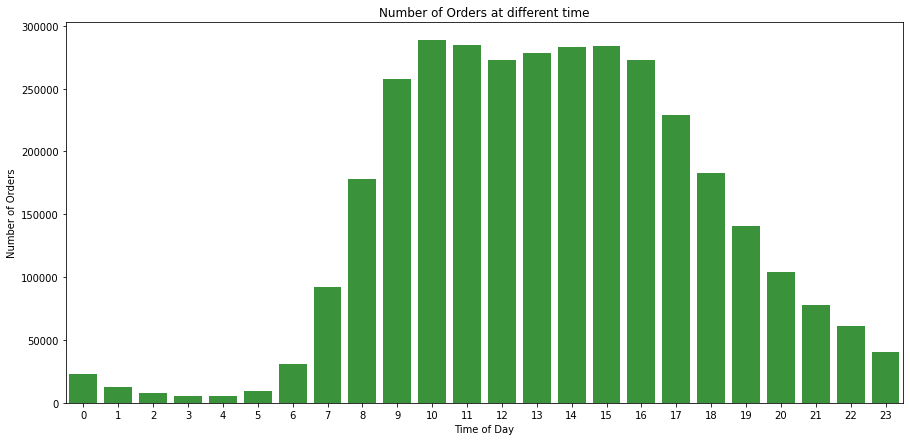

In [16]:
plt.figure(figsize=(15,7))
# orders['order_hour_of_day'].value_counts().plot(kind='bar')
sns.countplot(x="order_hour_of_day", data=orders, color=color[2])
plt.xlabel('Time of Day')
plt.ylabel('Number of Orders')
plt.title('Number of Orders at different time')
plt.show()

## Here we can observe that a major chuck of orders are being placed between 8am to 9pm and to be more specific during the afternoon time so that can be considered as a potential time period to enter an coupon code or offers to increase more sales and profit.

# Now lest see how the Hour of day conincide with the Day of week and see if there is any major change in the orderstime throughout the week.

In [17]:
group1 = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate('count').reset_index()
group1

,order_dow,order_hour_of_day,order_number
0,0,0,3936
1,0,1,2398
2,0,2,1409
3,0,3,963
4,0,4,813
...,...,...,...
163,6,19,18346
164,6,20,13392
165,6,21,10501
166,6,22,8532


In [18]:
group_pivot = group1.pivot('order_dow', 'order_hour_of_day', 'order_number')
group_pivot

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,3936,2398,1409,963,813,1168,3329,12410,28108,40798,...,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
1,3674,1830,1105,748,809,1607,5370,16571,34116,51908,...,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
2,3059,1572,943,719,744,1399,4758,13245,24635,36314,...,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
3,2952,1495,953,654,719,1355,4562,12396,22553,32312,...,34773,35990,35273,30368,25001,19249,13795,10278,8242,5181
4,2642,1512,899,686,730,1330,4401,12493,21814,31409,...,33625,34222,34093,29378,24425,19350,14186,10796,8812,5645
5,3189,1672,1016,841,910,1574,4866,13434,24015,34232,...,37407,37508,35860,29955,24310,18741,13322,9515,7498,5265
6,3306,1919,1214,863,802,1136,3243,11319,22960,30839,...,38748,38093,35562,30398,24157,18346,13392,10501,8532,6087


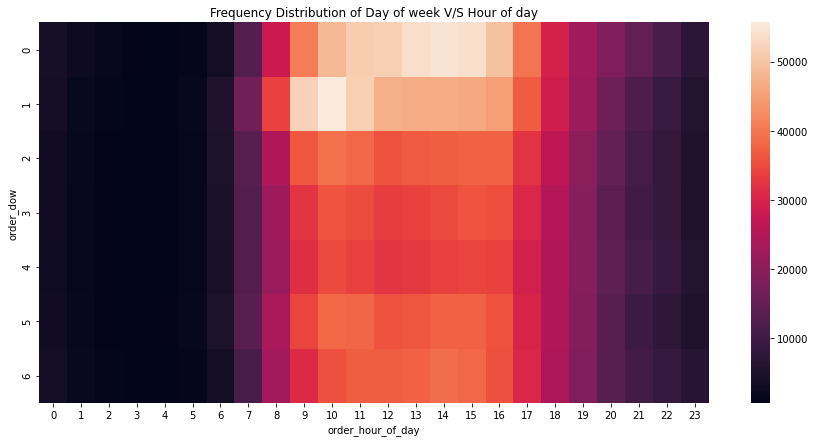

In [19]:
plt.figure(figsize=(15,7))
sns.heatmap(group_pivot)
plt.title("Frequency Distribution of Day of week V/S Hour of day")
plt.show()

## This also confirms our observation earlier where we said that the major chuck of orders are being placed between 8am to 9pm

# Top 15 commonly ordered products

In [20]:
product_info = pd.merge(product_priors, products, on= 'product_id')
product_info

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16
...,...,...,...,...,...,...,...
32434484,3265099,43492,3,0,Gourmet Burger Seasoning,104,13
32434485,3361945,43492,19,0,Gourmet Burger Seasoning,104,13
32434486,3267201,33097,2,0,Piquillo & Jalapeno Bruschetta,81,15
32434487,3393151,38977,32,0,Original Jerky,100,21


In [21]:
product_info['product_name'].value_counts().head(15)

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Organic Raspberries       137057
Organic Yellow Onion      113426
Organic Garlic            109778
Organic Zucchini          104823
Organic Blueberries       100060
Name: product_name, dtype: int64

# Least commonly ordered products

In [22]:
product_info['product_name'].value_counts().tail(15)

Blueberry Blast Fruit and Chia Seed Bar        1
Vegan Coconut Milk Caramels With Sea Salt      1
Kb Clb Stick Organic Fmly                      1
Salt & Vinegar Flavored Potato Crisps          1
Organic Veggie Ground                          1
All Natural Stevia Liquid Extract Sweetener    1
Vanilla Bean Sheep Milk Ice Cream              1
Chelated Magnesium 250 Mg Gluten Free          1
Coconut Cardamom Almond Butter                 1
Fruit Me Up!  Applesauce Pouches               1
Frittata, Farmer's Market                      1
Fig Balsamic Vinegar                           1
Punjabi Chhole, Hot Spicy                      1
Molasses, Bead                                 1
Flatbread Pizza All Natural                    1
Name: product_name, dtype: int64

# Reordered products compared with the number of times they have been ordered

In [23]:
group2 = product_info.groupby('product_name')['order_id','reordered'].aggregate({'order_id':len, 'reordered':sum})
group2

c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,order_id,reordered
product_name,,
#2 Coffee Filters,777,257
#2 Cone White Coffee Filters,13,3
#2 Mechanical Pencils,8,0
#4 Natural Brown Coffee Filters,241,89
& Go! Hazelnut Spread + Pretzel Sticks,164,87
...,...,...
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,37,17
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,55,19
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,68,31


In [24]:
group2['reorder_rate'] = round(group2.reordered/group2.order_id,2)

In [25]:
group2.rename(columns={'order_id':'order_count'},inplace=True)
group2.sort_values('reorder_rate',ascending=False)

,order_count,reordered,reorder_rate
product_name,,,
Raw Veggie Wrappers,68,64,0.94
Serenity Ultimate Extrema Overnight Pads,87,81,0.93
Orange Energy Shots,13,12,0.92
Chocolate Love Bar,101,93,0.92
Simply Sleep Nighttime Sleep Aid,45,41,0.91
...,...,...,...
Pappardelle Nests Pasta,1,0,0.00
Apple Cortland,12,0,0.00
Apple Cranberry Chutney,8,0,0.00


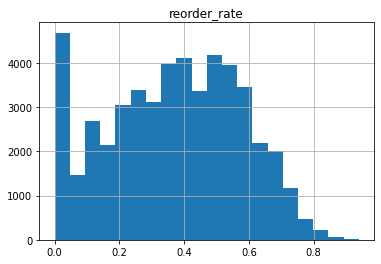

In [26]:
group2.hist(column='reorder_rate',bins=20)
plt.show()

## In the histogram above it seems that a good threshold to find the top most reordered items would be around 0.70-0.75 so I am chossing 0.70 here to get a better understanding of things.

In [27]:
group2

,order_count,reordered,reorder_rate
product_name,,,
#2 Coffee Filters,777,257,0.33
#2 Cone White Coffee Filters,13,3,0.23
#2 Mechanical Pencils,8,0,0.00
#4 Natural Brown Coffee Filters,241,89,0.37
& Go! Hazelnut Spread + Pretzel Sticks,164,87,0.53
...,...,...,...
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,37,17,0.46
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,55,19,0.35
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,68,31,0.46


In [28]:
group2.columns

Index(['order_count', 'reordered', 'reorder_rate'], dtype='object')

In [29]:
high_reorder = group2[group2.reorder_rate>0.70].sort_values('reorder_rate',ascending=False)
high_reorder

,order_count,reordered,reorder_rate
product_name,,,
Raw Veggie Wrappers,68,64,0.94
Serenity Ultimate Extrema Overnight Pads,87,81,0.93
Orange Energy Shots,13,12,0.92
Chocolate Love Bar,101,93,0.92
"Energy Shot, Grape Flavor",22,20,0.91
...,...,...,...
Double Strength Energy Drink,201,143,0.71
Boost Cherry Energy Drink,7,5,0.71
Organic Love Crunch Granola Dark Chocolate & Red Berries,3650,2574,0.71


In [30]:
def top_reordered_products(top):
    plt.figure(figsize=(12, 8))
    sns.barplot(x=high_reorder.reorder_rate[:top], y=high_reorder.index[:top])
    plt.xlabel('Reorder probability')
    plt.ylabel('Product Name')
    plt.title('Product Reordering Probability')
    plt.show()

# Top 10 Products with highest reorder_rate

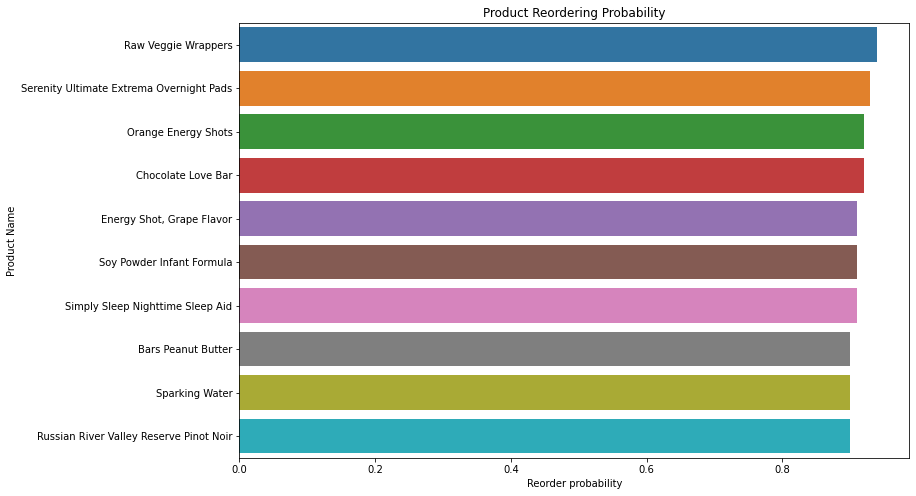

In [31]:
top_reordered_products(10)

# Top 20 Products with highest reorder_rate

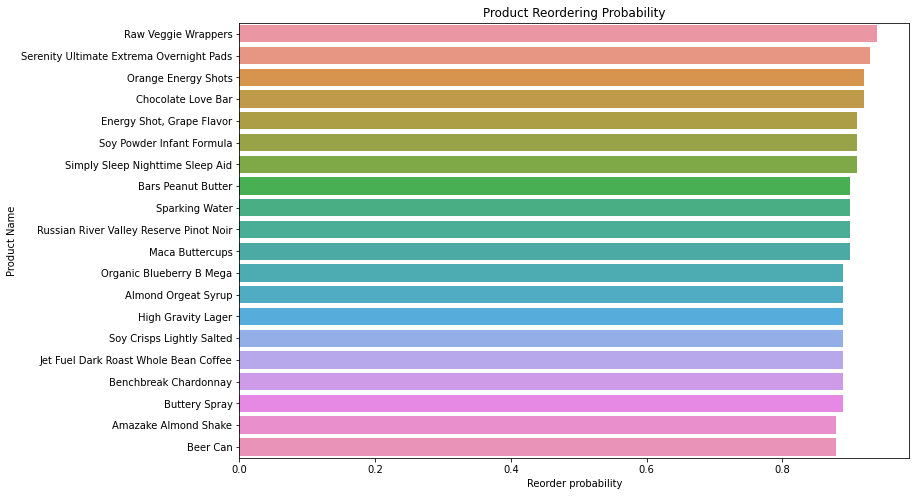

In [32]:
top_reordered_products(20)

## This helps us understand which products do we need hvae more qunatity wise and also try and make sure they are available in the nearest warehouse

# Aisle and Number of Products available in each aisle

In [55]:
aisles_info = pd.merge(products,aisles,on='aisle_id')
aisles_info

,product_id,product_name,aisle_id,department_id,aisle
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes
2,102,Danish Butter Cookies,61,19,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes
...,...,...,...,...,...
49683,47769,Peas and Potatoe Roti Paratha,76,6,indian foods
49684,48292,Punjabi Chhole Chickpeas with Potatoes & Onions,76,6,indian foods
49685,48480,Punjab Eggplant,76,6,indian foods
49686,48830,Pav Bhaji Mashed Vegetable Curry,76,6,indian foods


In [57]:
aisles_info_grp = aisles_info.groupby('aisle')['product_id'].aggregate('count')
aisles_info_grp

aisle
air fresheners candles            355
asian foods                       605
baby accessories                   44
baby bath body care               132
baby food formula                 718
                                 ... 
trash bags liners                 112
vitamins supplements             1038
water seltzer sparkling water     344
white wines                       147
yogurt                           1026
Name: product_id, Length: 134, dtype: int64

In [60]:
aisles_info_grp.sort_values(ascending=False).head(10)

aisle
missing                 1258
candy chocolate         1246
ice cream ice           1091
vitamins supplements    1038
yogurt                  1026
chips pretzels           989
tea                      894
packaged cheese          891
frozen meals             880
cookies cakes            874
Name: product_id, dtype: int64

## The above table helps us understand which aisles we can keep an eye on to check if they need any restocking

# Department and Number of Products available in each department

In [85]:
dept_info = pd.merge(left=products, right=dept, how='left')
dept_info.head()

,product_id,product_name,aisle_id,department_id,department
0,1,Chocolate Sandwich Cookies,61,19,snacks
1,2,All-Seasons Salt,104,13,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen
4,5,Green Chile Anytime Sauce,5,13,pantry


In [86]:
dept_info = dept_info.groupby('department')['product_id'].aggregate('count').sort_values(ascending=False)
dept_info

department
personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets                972
meat seafood        907
other               548
bulk                 38
Name: product_id, dtype: int64

In [90]:
dept_info.values

array([6563, 6264, 5371, 4365, 4007, 3449, 3085, 2092, 1858, 1684, 1516,
       1322, 1258, 1139, 1115, 1081, 1054,  972,  907,  548,   38],
      dtype=int64)

c:\programdata\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


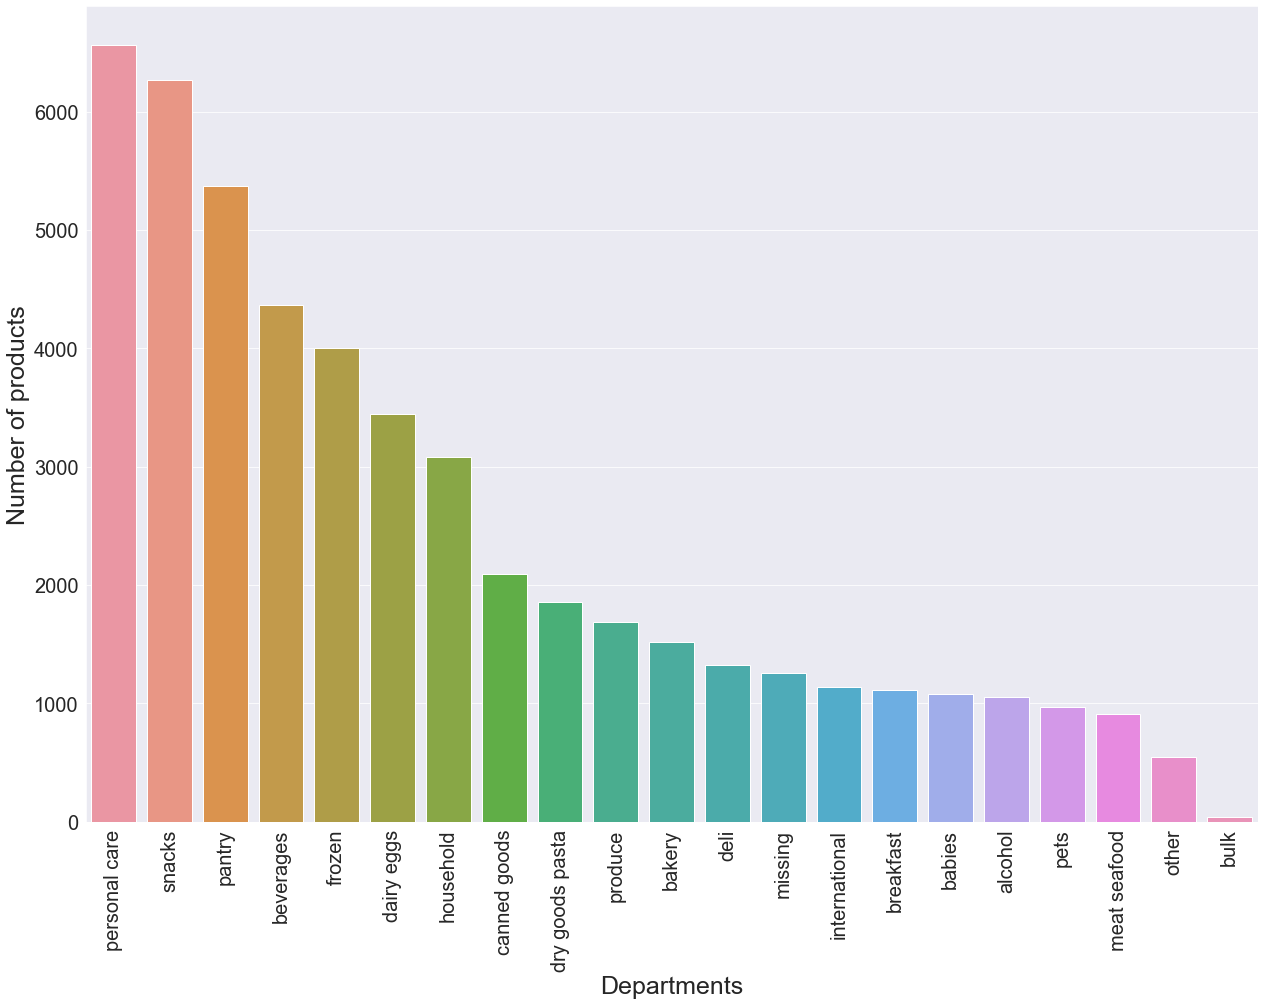

In [97]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(21, 15))
plt.xticks(rotation='vertical',fontsize=20)
plt.yticks(fontsize=20)
sns.barplot(dept_info.index, dept_info.values)
plt.ylabel('Number of products', fontsize=25)
plt.xlabel('Departments', fontsize=25)
plt.show()

## Based on the above plot we can see that personal care, food and beverages departments consists of products that are being order most often.

In [118]:
"Done".lower()

'done'

# Lets explore the food section to see if people are ordering organic food or inorganic food more often.

## We will find all the products that contains organic in the name to find organic food

In [128]:
organic = products[products['product_name'].str.lower().str.contains('organic')]
non_organic = products[~products['product_name'].str.lower().str.contains('organic', case=False)]

In [152]:
organic_count = len(organic)
non_organic_count = len(non_organic)


organic['Key'] = 'organic'
non_organic['Key'] = 'non-organic'

foods = pd.merge(organic.iloc[:,[0,-1]],non_organic.iloc[:,[0,-1]],how = 'outer', on='product_id')
foods.drop('product_id',axis=1,inplace=True)
foods.rename(columns={'Key_x':'Organic','Key_y':'Non_Organic'},inplace=True)
foods= foods.count()

In [157]:
organic = round(foods.Organic/(foods.Organic+foods.Non_Organic)*100,2)
non_organic = round(foods.Non_Organic/(foods.Organic+foods.Non_Organic)*100,2)
print(organic,non_organic)

10.14 89.86


In [179]:
data = {'Organic':[organic],'Non_Organic':[non_organic]}
food = pd.DataFrame(data ,columns = ['Organic','Non_Organic'])
food

,Organic,Non_Organic
0,10.14,89.86


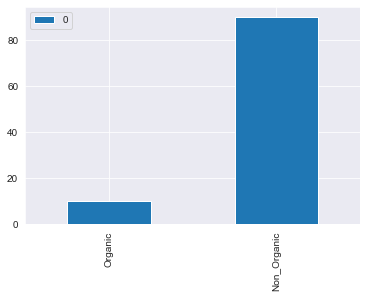

In [181]:
food.T.plot(kind='bar')
plt.show()

# Common Number of Products in an Order
### The number of times people of ordered x number of products in an order

In [36]:
user_group = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
# user_group = user_group.groupby('user_id_id').aggregate("count")
user_group.rename(columns={'order_id':'number_of_orders'},inplace=True)

In [42]:
order_count = user_group.groupby('number_of_orders').aggregate('count')
order_count.rename(columns={'user_id':'count_of_people'},inplace=True)
order_count

,count_of_people
number_of_orders,
4,23986
5,19590
6,16165
7,13850
8,11700
...,...
96,67
97,54
98,50


c:\programdata\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


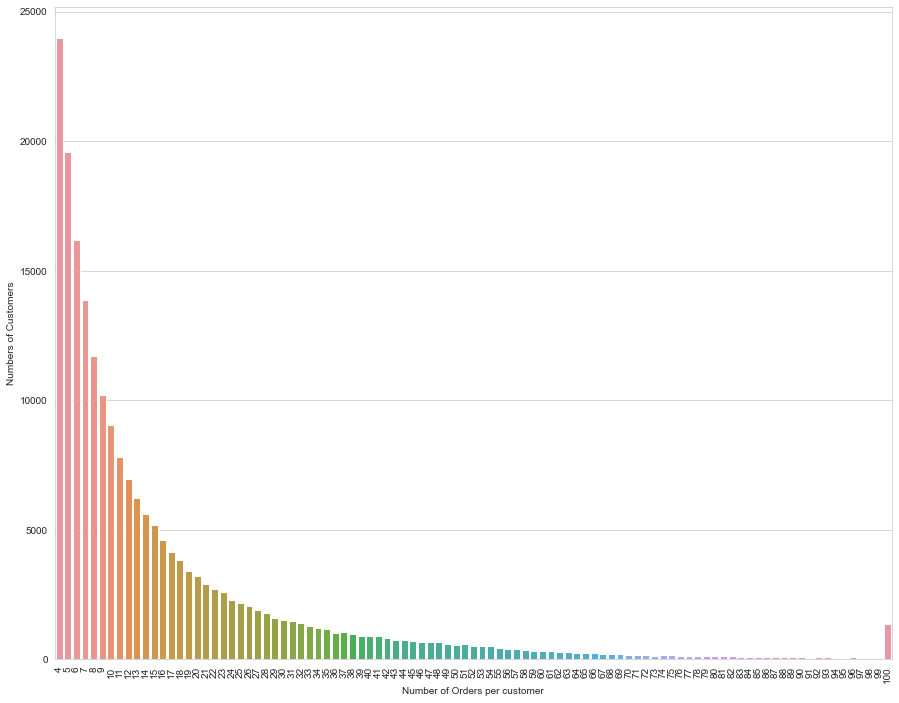

In [41]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(order_count.index, order_count.count_of_people)
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

## The number of products in each order is usually around 4-20 where 4-9 are the most common and the number of products ordered are between 4-9 around 50% of the times.

In [51]:
sum(order_count['count_of_people'][:6])/sum(order_count['count_of_people'])

0.46303022661474524

# Most frequently ordered products Vs Number of orders containing these products.

In [182]:
goods = pd.merge(left=pd.merge(left=products, right=dept, how='left'), right=aisles, how='left')
# to retain '-' and make product names more "standard"
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower()

In [183]:
goods

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,chocolate_sandwich_cookies,61,19,snacks,cookies cakes
1,2,all-seasons_salt,104,13,pantry,spices seasonings
2,3,robust_golden_unsweetened_oolong_tea,94,7,beverages,tea
3,4,smart_ones_classic_favorites_mini_rigatoni_wit...,38,1,frozen,frozen meals
4,5,green_chile_anytime_sauce,5,13,pantry,marinades meat preparation
...,...,...,...,...,...,...
49683,49684,"vodka,_triple_distilled,_twist_of_vanilla",124,5,alcohol,spirits
49684,49685,en_croute_roast_hazelnut_cranberry,42,1,frozen,frozen vegan vegetarian
49685,49686,artisan_baguette,112,3,bakery,bread
49686,49687,smartblend_healthy_metabolism_dry_cat_food,41,8,pets,cat food care


Wall time: 4.47 s


c:\programdata\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Product Name')

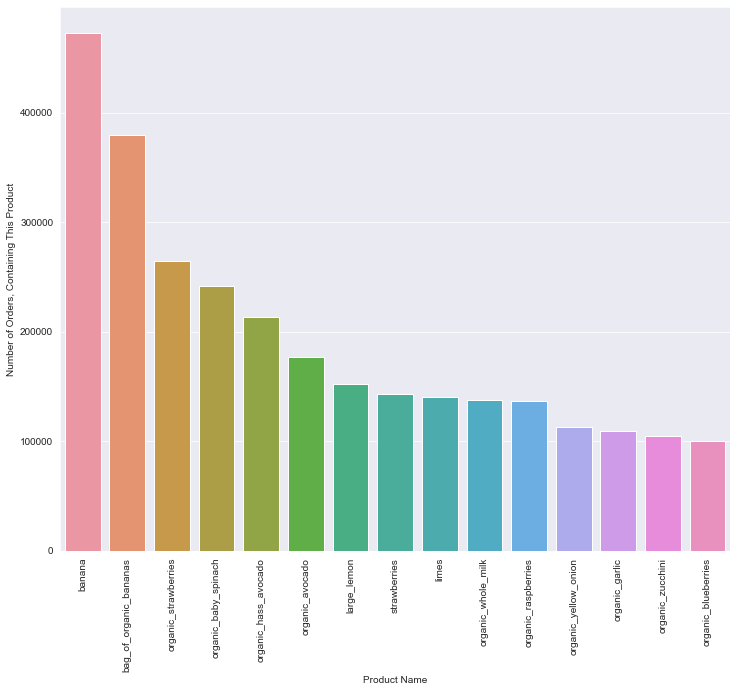

In [186]:
%%time
# popular products (total set, not only train)
top = 15
top_products = pd.merge(
    # to see train: 
    # left=pd.DataFrame(order_details[order_details.eval_set == 'train'].groupby(['product_id'])['order_id']\
    left=pd.DataFrame(product_info.groupby(['product_id'])['order_id']\
    .apply(lambda x: len(x.unique())).sort_values(ascending=False)[:top].reset_index('product_id')),
    right=goods,
    how='left')

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(top_products.product_name, top_products.order_id)
plt.ylabel('Number of Orders, Containing This Product')
plt.xlabel('Product Name')

# Number of Orders Vs Number of products in an order.

Most common order contains: 5 products


c:\programdata\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 50.0)

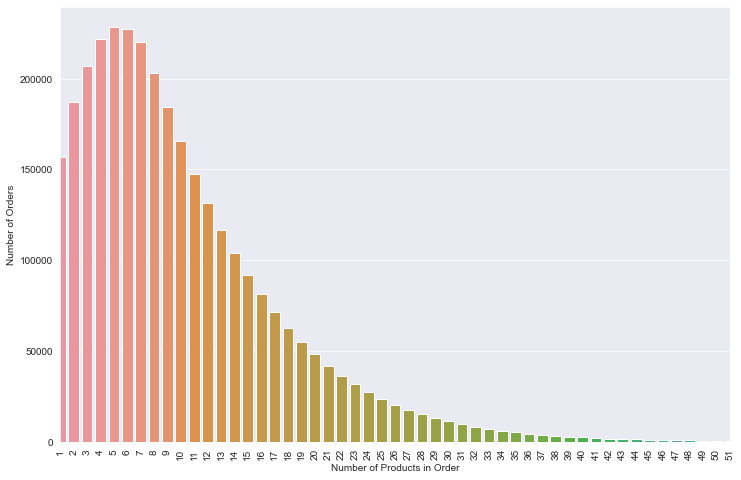

In [187]:
ord_by_prods = product_info.groupby("order_id")["add_to_cart_order"]\
.aggregate(np.max).reset_index()['add_to_cart_order'].value_counts()

print('Most common order contains: {} products'.format(
    ord_by_prods[ord_by_prods.values == ord_by_prods.max()].index.values[0]))

# plot it
plt.figure(figsize=(12, 8))
plt.xticks(rotation='vertical')
sns.barplot(ord_by_prods.index, ord_by_prods.values)
plt.ylabel('Number of Orders')
plt.xlabel('Number of Products in Order')
plt.xlim([0, 50])